In [1]:
#!pip3 install pandas seaborn matplotlib numpy statsmodels
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import warnings

warnings.filterwarnings('ignore')


In [2]:
data = pd.read_parquet("../src/preprocessing/data/raw/raw_stock_data.parquet")
data.head(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
1993-01-29 00:00:00-05:00,24.39779,24.39779,24.276408,24.380449,1003200,0.0,0.0,0.0


In [3]:
data.tail(1)

,Open,High,Low,Close,Volume,Dividends,Stock Splits,Capital Gains
Date,,,,,,,,
2025-09-12 00:00:00-04:00,657.599976,659.109985,656.900024,657.409973,72708800,0.0,0.0,0.0


In [4]:
# Dibujar los últimos 10 años

data = data.reset_index()


<Axes: xlabel='Date', ylabel='Close'>

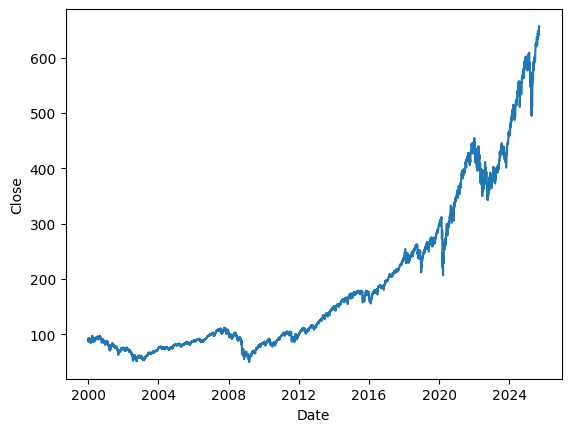

In [5]:
last_years = data[data["Date"]>='2000-01-01']

sns.lineplot(x="Date", y="Close", data=last_years)


In [6]:
data.dtypes

Date             datetime64[ns, America/New_York]
Open                                      float64
High                                      float64
Low                                       float64
Close                                     float64
Volume                                      int64
Dividends                                 float64
Stock Splits                              float64
Capital Gains                             float64
dtype: object

In [7]:
ts = data.set_index("Date")["Close"]
ts

Date
1993-01-29 00:00:00-05:00     24.380449
1993-02-01 00:00:00-05:00     24.553848
1993-02-02 00:00:00-05:00     24.605879
1993-02-03 00:00:00-05:00     24.865967
1993-02-04 00:00:00-05:00     24.970003
                                ...    
2025-09-08 00:00:00-04:00    648.830017
2025-09-09 00:00:00-04:00    650.330017
2025-09-10 00:00:00-04:00    652.210022
2025-09-11 00:00:00-04:00    657.630005
2025-09-12 00:00:00-04:00    657.409973
Name: Close, Length: 8212, dtype: float64

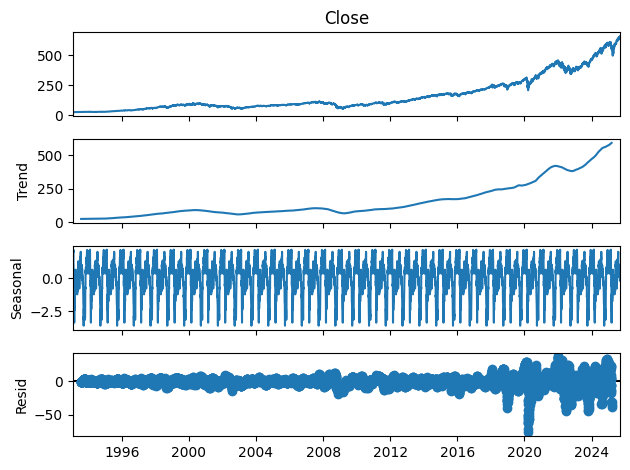

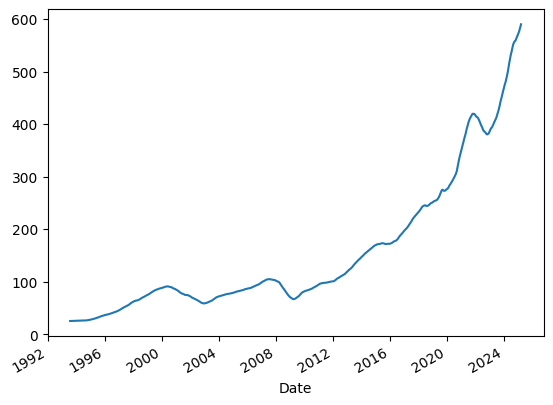

In [8]:
# Descomposición de series de tiempo
import statsmodels
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(ts, period=252, model='additive')
decomposition.plot()
plt.show()

decomposition.trend.plot()
plt.show()


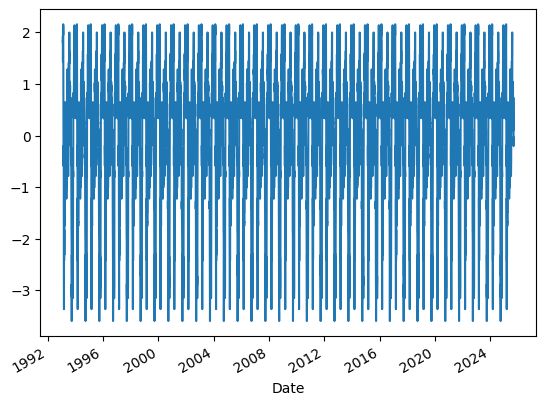

In [9]:
decomposition.seasonal.plot()
plt.show()



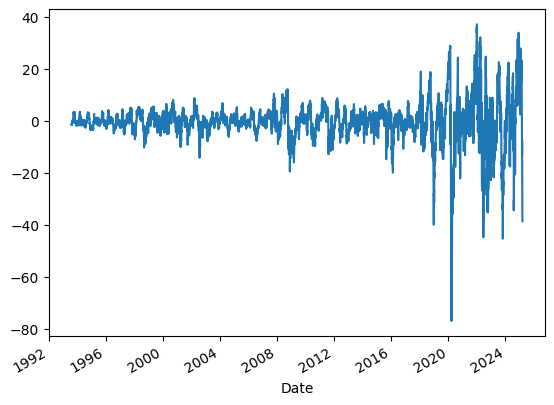

In [10]:
decomposition.resid.plot()
plt.show()

In [11]:
from statsmodels.tsa.stattools import adfuller
import pandas as pd

# Función para realizar e interpretar el test ADF
def adf_test(timeseries, title=''):
    """
    Realiza el test de Dickey-Fuller Aumentado
    H0: La serie tiene raíz unitaria (no es estacionaria)
    H1: La serie es estacionaria
    """
    print(f'Resultados del Test de Dickey-Fuller para {title}:')
    print('-' * 50)
    
    # Realizar el test
    dftest = adfuller(timeseries, autolag='AIC')
    
    # Organizar resultados
    dfoutput = pd.Series(dftest[0:4], index=[
        'Estadístico ADF',
        'p-value',
        'Lags utilizados',
        'Número de observaciones'
    ])
    
    # Valores críticos
    for key, value in dftest[4].items():
        dfoutput[f'Valor crítico ({key})'] = value
    
    print(dfoutput)
    print()
    
    # Interpretación
    if dftest[1] <= 0.05:
        print("✅ RESULTADO: Rechazamos H0 - La serie ES ESTACIONARIA")
        print(f"   p-value ({dftest[1]:.6f}) <= 0.05")
    else:
        print("❌ RESULTADO: No rechazamos H0 - La serie NO ES ESTACIONARIA")
        print(f"   p-value ({dftest[1]:.6f}) > 0.05")
    
    print()
    return dftest


adf_original = adf_test(ts, 'Serie Original')


Resultados del Test de Dickey-Fuller para Serie Original:
--------------------------------------------------
Estadístico ADF               3.911860
p-value                       1.000000
Lags utilizados              30.000000
Número de observaciones    8181.000000
Valor crítico (1%)           -3.431150
Valor crítico (5%)           -2.861893
Valor crítico (10%)          -2.566958
dtype: float64

❌ RESULTADO: No rechazamos H0 - La serie NO ES ESTACIONARIA
   p-value (1.000000) > 0.05



In [12]:
ts

Date
1993-01-29 00:00:00-05:00     24.380449
1993-02-01 00:00:00-05:00     24.553848
1993-02-02 00:00:00-05:00     24.605879
1993-02-03 00:00:00-05:00     24.865967
1993-02-04 00:00:00-05:00     24.970003
                                ...    
2025-09-08 00:00:00-04:00    648.830017
2025-09-09 00:00:00-04:00    650.330017
2025-09-10 00:00:00-04:00    652.210022
2025-09-11 00:00:00-04:00    657.630005
2025-09-12 00:00:00-04:00    657.409973
Name: Close, Length: 8212, dtype: float64

In [13]:
dts = ts.diff().dropna()
adf_diff = adf_test(dts, 'Serie Diferenciada')



Resultados del Test de Dickey-Fuller para Serie Diferenciada:
--------------------------------------------------
Estadístico ADF           -1.741133e+01
p-value                    4.883933e-30
Lags utilizados            2.800000e+01
Número de observaciones    8.182000e+03
Valor crítico (1%)        -3.431149e+00
Valor crítico (5%)        -2.861893e+00
Valor crítico (10%)       -2.566958e+00
dtype: float64

✅ RESULTADO: Rechazamos H0 - La serie ES ESTACIONARIA
   p-value (0.000000) <= 0.05



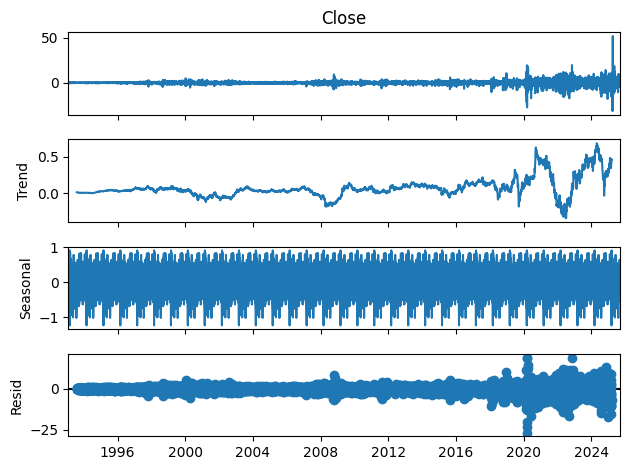

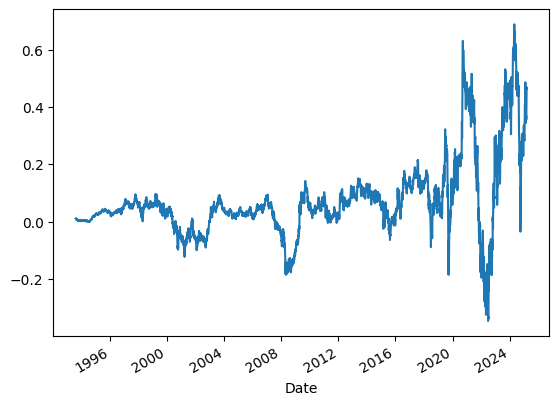

In [14]:
import statsmodels
decomposition = statsmodels.tsa.seasonal.seasonal_decompose(dts, period=252, model='additive')
decomposition.plot()
plt.show()

decomposition.trend.plot()
plt.show()

<Figure size 1200x600 with 0 Axes>

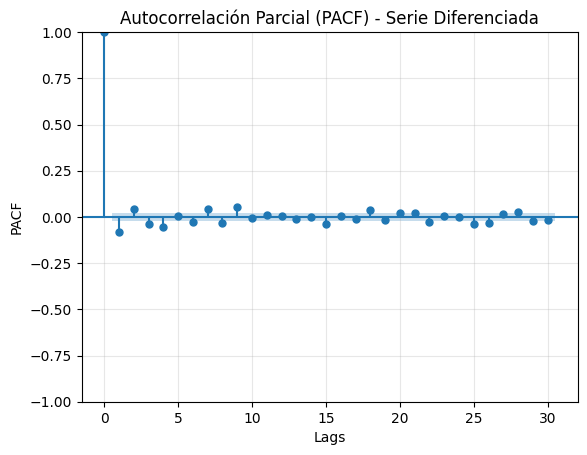

<Figure size 1200x600 with 0 Axes>

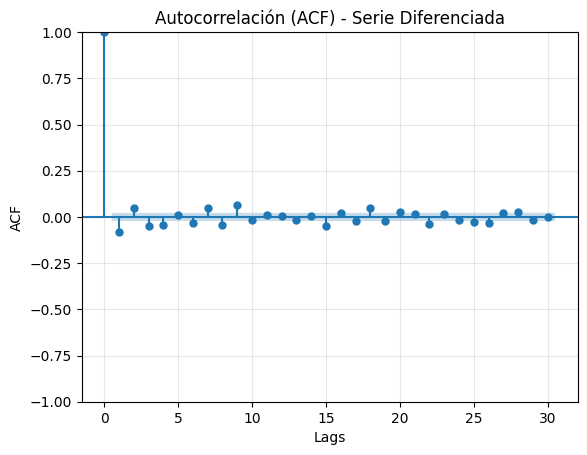

In [15]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

# Gráfico de Autocorrelación Parcial (PACF)
def grafico_pacf(serie, lags=20, titulo=""):
    """
    Crea gráfico de autocorrelación parcial
    """
    plt.figure(figsize=(12, 6))
    plot_pacf(serie, lags=lags, alpha=0.05, method='ywm')
    plt.title(f'Autocorrelación Parcial (PACF) - {titulo}')
    plt.xlabel('Lags')
    plt.ylabel('PACF')
    plt.grid(True, alpha=0.3)
    plt.show()

# Gráfico de Autocorrelación (ACF)
def grafico_acf(serie, lags=20, titulo=""):
    """
    Crea gráfico de autocorrelación
    """
    plt.figure(figsize=(12, 6))
    plot_acf(serie, lags=lags, alpha=0.05)
    plt.title(f'Autocorrelación (ACF) - {titulo}')
    plt.xlabel('Lags')
    plt.ylabel('ACF')
    plt.grid(True, alpha=0.3)
    plt.show()

# Usar las funciones
grafico_pacf(dts, lags=30, titulo="Serie Diferenciada")
grafico_acf(dts, lags=30, titulo="Serie Diferenciada")

<Figure size 1200x600 with 0 Axes>

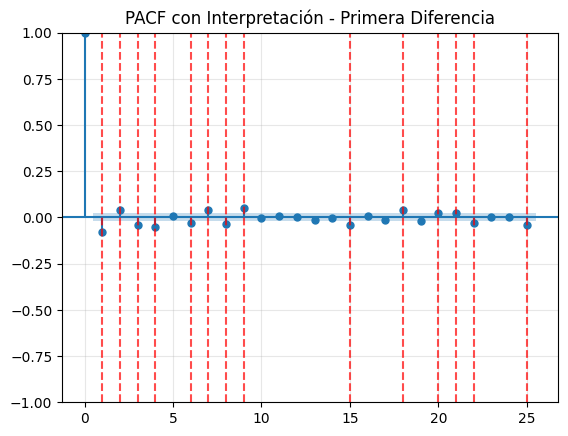

📊 INTERPRETACIÓN PACF - Primera Diferencia
Lags significativos: [1, 2, 3, 4, 6, 7, 8, 9, 15, 18, 20, 21, 22, 25]
Orden AR sugerido (p): 25


In [16]:
from statsmodels.tsa.stattools import pacf, acf

def pacf_con_interpretacion(serie, lags=20, titulo=""):
    """
    PACF con interpretación automática para determinar orden AR
    """
    # Calcular PACF
    pacf_values, confint = pacf(serie, nlags=lags, alpha=0.05)
    
    # Encontrar lags significativos
    lags_significativos = []
    for i in range(1, len(pacf_values)):
        if abs(pacf_values[i]) > abs(confint[i, 1] - pacf_values[i]):
            lags_significativos.append(i)
    
    # Graficar
    plt.figure(figsize=(12, 6))
    plot_pacf(serie, lags=lags, alpha=0.05, method='ywm')
    plt.title(f'PACF con Interpretación - {titulo}')
    plt.grid(True, alpha=0.3)
    
    # Marcar lags significativos
    for lag in lags_significativos:
        plt.axvline(x=lag, color='red', linestyle='--', alpha=0.7)
    
    plt.show()
    
    # Interpretación
    print(f"📊 INTERPRETACIÓN PACF - {titulo}")
    print("="*50)
    print(f"Lags significativos: {lags_significativos}")
    
    if len(lags_significativos) > 0:
        p_sugerido = max(lags_significativos)
        print(f"Orden AR sugerido (p): {p_sugerido}")
    else:
        print("No se detectaron lags significativos")
        print("Orden AR sugerido (p): 0")
    
    return lags_significativos

# Usar con interpretación
lags_sig = pacf_con_interpretacion(ts.diff().dropna(), lags=25, titulo="Primera Diferencia")

In [17]:
# Esquema de validación

train = dts.loc[:'2023-12-31']
test = dts.loc['2024-01-01':]

print(train.index.max())
print(test.index.min())


len(test)



2023-12-29 00:00:00-05:00
2024-01-02 00:00:00-05:00


426

In [18]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
def crear_modelo_arima(serie, orden=(1,1,1)):
    """
    Crea y ajusta un modelo ARIMA
    orden = (p, d, q) donde:
    p = orden AR (autoregresivo)
    d = orden de diferenciación
    q = orden MA (media móvil)
    """
    print(f"🔧 Creando modelo ARIMA{orden}")
    
    # Crear el modelo
    modelo = ARIMA(serie, order=orden)
    
    # Ajustar el modelo
    modelo_ajustado = modelo.fit()
    
    # Mostrar resumen
    print(modelo_ajustado.summary())
    
    return modelo_ajustado

# Ejemplo de uso
modelo = crear_modelo_arima(train.loc["2021-01-01":], orden=(25,0,10)) # Diversas pruebas

🔧 Creando modelo ARIMA(25, 0, 10)
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  753
Model:               ARIMA(25, 0, 10)   Log Likelihood               -2156.676
Date:                Sun, 28 Sep 2025   AIC                           4387.352
Time:                        16:48:47   BIC                           4558.443
Sample:                             0   HQIC                          4453.265
                                - 753                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.1426      0.133      1.069      0.285      -0.119       0.404
ar.L1         -0.0721      0.454     -0.159      0.874      -0.962       0.818
ar.L2          0.1

426
426


<Axes: xlabel='Date', ylabel='Close'>

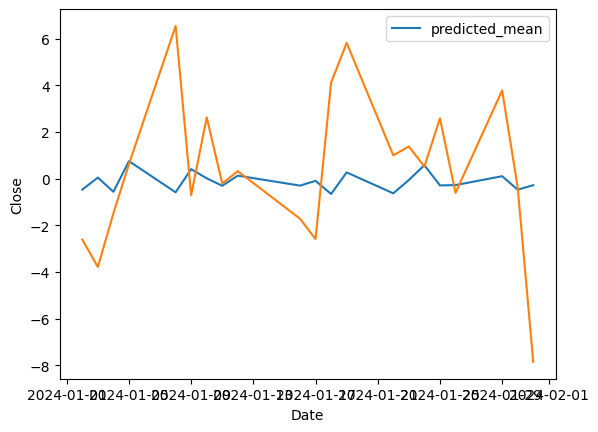

In [19]:
forecast = modelo.forecast(steps=426)
conf_int = modelo.get_forecast(steps=426).conf_int()

print(  len(forecast))
print(len(test))


df_forecast = pd.DataFrame(forecast)
df_forecast.index = test.index


sns.lineplot(df_forecast.loc[:"2024-01-31"])
sns.lineplot(test.loc[:"2024-01-31"])



In [20]:
import itertools
import warnings
from statsmodels.tsa.arima.model import ARIMA
import pandas as pd
warnings.filterwarnings('ignore')

def auto_arima_manual(serie, max_p=30, max_d=0, max_q=30, criterio='aic'):
    """
    Implementación manual de auto_arima usando solo statsmodels
    """
    print("🔍 Búsqueda automática de parámetros ARIMA (versión manual)...")
    
    # Generar todas las combinaciones
    p_values = range(0, max_p + 1)
    d_values = range(0, max_d + 1)  
    q_values = range(0, max_q + 1)
    
    best_score = float("inf")
    best_order = None
    best_model = None
    resultados = []
    
    for p, d, q in itertools.product(p_values, d_values, q_values):
        try:
            # Crear y ajustar modelo
            modelo = ARIMA(serie, order=(p, d, q))
            modelo_ajustado = modelo.fit()
            
            # Obtener criterio de información
            if criterio == 'aic':
                score = modelo_ajustado.aic
            elif criterio == 'bic':
                score = modelo_ajustado.bic
            else:
                score = modelo_ajustado.aic
                
            resultados.append({
                'Orden': (p, d, q),
                'AIC': modelo_ajustado.aic,
                'BIC': modelo_ajustado.bic,
                'LogLik': modelo_ajustado.llf
            })
            
            print(f"ARIMA({p},{d},{q}) - AIC: {modelo_ajustado.aic:.2f}, BIC: {modelo_ajustado.bic:.2f}")
            
            # Actualizar mejor modelo
            if score < best_score:
                best_score = score
                best_order = (p, d, q)
                best_model = modelo_ajustado
                
        except Exception as e:
            print(f"❌ Error con ARIMA({p},{d},{q}): {str(e)[:50]}...")
            continue
    
    # Crear DataFrame con resultados
    df_resultados = pd.DataFrame(resultados)
    df_resultados = df_resultados.sort_values('AIC')
    
    print(f"\n✅ Mejor modelo: ARIMA{best_order}")
    print(f"   {criterio.upper()}: {best_score:.2f}")
    
    return best_model, best_order, df_resultados

# Usar la función
mejor_modelo, mejor_orden, tabla_resultados = auto_arima_manual(dts, max_p=30, max_d=0, max_q=30)

🔍 Búsqueda automática de parámetros ARIMA (versión manual)...
ARIMA(0,0,0) - AIC: 37332.25, BIC: 37346.28
ARIMA(0,0,1) - AIC: 37286.13, BIC: 37307.17
ARIMA(0,0,2) - AIC: 37274.43, BIC: 37302.48
ARIMA(0,0,3) - AIC: 37251.87, BIC: 37286.94
ARIMA(0,0,4) - AIC: 37241.19, BIC: 37283.27
ARIMA(0,0,5) - AIC: 37242.88, BIC: 37291.97


KeyboardInterrupt: 

<Axes: xlabel='Date'>

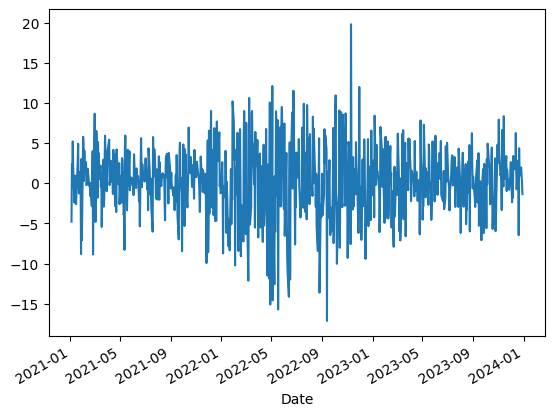

In [21]:
train.loc["2021-01-01":].plot()

In [22]:
# Datasets

import pandas as pd
import numpy as np
from statsmodels.tsa.statespace.sarimax import SARIMAX
import matplotlib.pyplot as plt

def crear_variable_exogena_segura(serie, periodos_eventos, nombre_evento="evento"):
    """
    Versión segura que maneja zonas horarias automáticamente
    """
    print(f"🔧 Creando variable exógena para {nombre_evento} (versión segura)...")
    
    # Normalizar serie
    serie_trabajo = serie.copy()
    
    # Manejar zona horaria de la serie
    if hasattr(serie_trabajo.index, 'tz') and serie_trabajo.index.tz is not None:
        print(f"Convirtiendo de zona horaria: {serie_trabajo.index.tz}")
        serie_trabajo.index = serie_trabajo.index.tz_convert('UTC').tz_localize(None)
    else:
        serie_trabajo.index = pd.to_datetime(serie_trabajo.index, utc=False).tz_localize(None)
    
    # Crear variable exógena
    variable_exogena = pd.Series(0, index=serie_trabajo.index, name=f'{nombre_evento}_flag')
    
    eventos_marcados = 0
    for i, (fecha_inicio, fecha_fin) in enumerate(periodos_eventos):
        try:
            # Normalizar fechas de eventos
            inicio = pd.to_datetime(fecha_inicio, utc=False).tz_localize(None)
            fin = pd.to_datetime(fecha_fin, utc=False).tz_localize(None)
            
            # Verificar que las fechas están en el rango de la serie
            if inicio > serie_trabajo.index.max() or fin < serie_trabajo.index.min():
                print(f"  ⚠️ Período {i+1} fuera del rango de datos: {inicio} a {fin}")
                continue
            
            # Marcar período
            mask = (serie_trabajo.index >= inicio) & (serie_trabajo.index <= fin)
            variable_exogena[mask] = 1
            
            puntos_marcados = mask.sum()
            eventos_marcados += puntos_marcados
            print(f"  ✅ Período {i+1}: {inicio.date()} a {fin.date()} - {puntos_marcados} puntos")
            
        except Exception as e:
            print(f"  ❌ Error en período {i+1}: {e}")
            continue
    
    print(f"✅ Total marcado: {eventos_marcados}/{len(serie_trabajo)} puntos")
    
    return variable_exogena, serie_trabajo

# Usar función segura


# Definir períodos de eventos importantes
periodos = [
    ['2022-02-01', "2022-04-01"],
    ["2023-03-01", "2023-05-01"],
    ["2024-02-01", "2024-04-01"],
    ["2025-02-01", "2025-04-01"],  # Este período podría estar fuera del rango
]

# Crear variable exógena
evento_flag_seguro, dts_seguro = crear_variable_exogena_segura(dts, periodos, "evento_importante")



dts_seguro

🔧 Creando variable exógena para evento_importante (versión segura)...
Convirtiendo de zona horaria: America/New_York
  ✅ Período 1: 2022-02-01 a 2022-04-01 - 42 puntos
  ✅ Período 2: 2023-03-01 a 2023-05-01 - 42 puntos
  ✅ Período 3: 2024-02-01 a 2024-04-01 - 40 puntos
  ✅ Período 4: 2025-02-01 a 2025-04-01 - 40 puntos
✅ Total marcado: 164/8211 puntos


Date
1993-02-01 05:00:00    0.173399
1993-02-02 05:00:00    0.052031
1993-02-03 05:00:00    0.260088
1993-02-04 05:00:00    0.104036
1993-02-05 05:00:00   -0.017317
                         ...   
2025-09-08 04:00:00    1.590027
2025-09-09 04:00:00    1.500000
2025-09-10 04:00:00    1.880005
2025-09-11 04:00:00    5.419983
2025-09-12 04:00:00   -0.220032
Name: Close, Length: 8211, dtype: float64

🚀 PIPELINE SARIMAX CORREGIDO - Precio SPY500

2️⃣ Creando variables exógenas...
🔧 Creando variable exógena para evento (versión segura)...
Convirtiendo de zona horaria: America/New_York
  ✅ Período 1: 2022-02-01 a 2022-04-01 - 42 puntos
  ✅ Período 2: 2023-03-01 a 2023-05-01 - 42 puntos
  ⚠️ Período 3 fuera del rango de datos: 2024-02-01 00:00:00 a 2024-04-01 00:00:00
  ⚠️ Período 4 fuera del rango de datos: 2025-02-01 00:00:00 a 2025-04-01 00:00:00
✅ Total marcado: 84/753 puntos

3️⃣ Entrenando modelo SARIMAX...
Variables exógenas: 84 eventos de 753 total
✅ Modelo SARIMAX entrenado exitosamente
AIC: 4319.52

4️⃣ Resumen del modelo:
                               SARIMAX Results                                
Dep. Variable:                  Close   No. Observations:                  753
Model:             SARIMAX(10, 0, 10)   Log Likelihood               -2137.758
Date:                Sun, 28 Sep 2025   AIC                           4319.515
Time:                        16:49:51   BIC

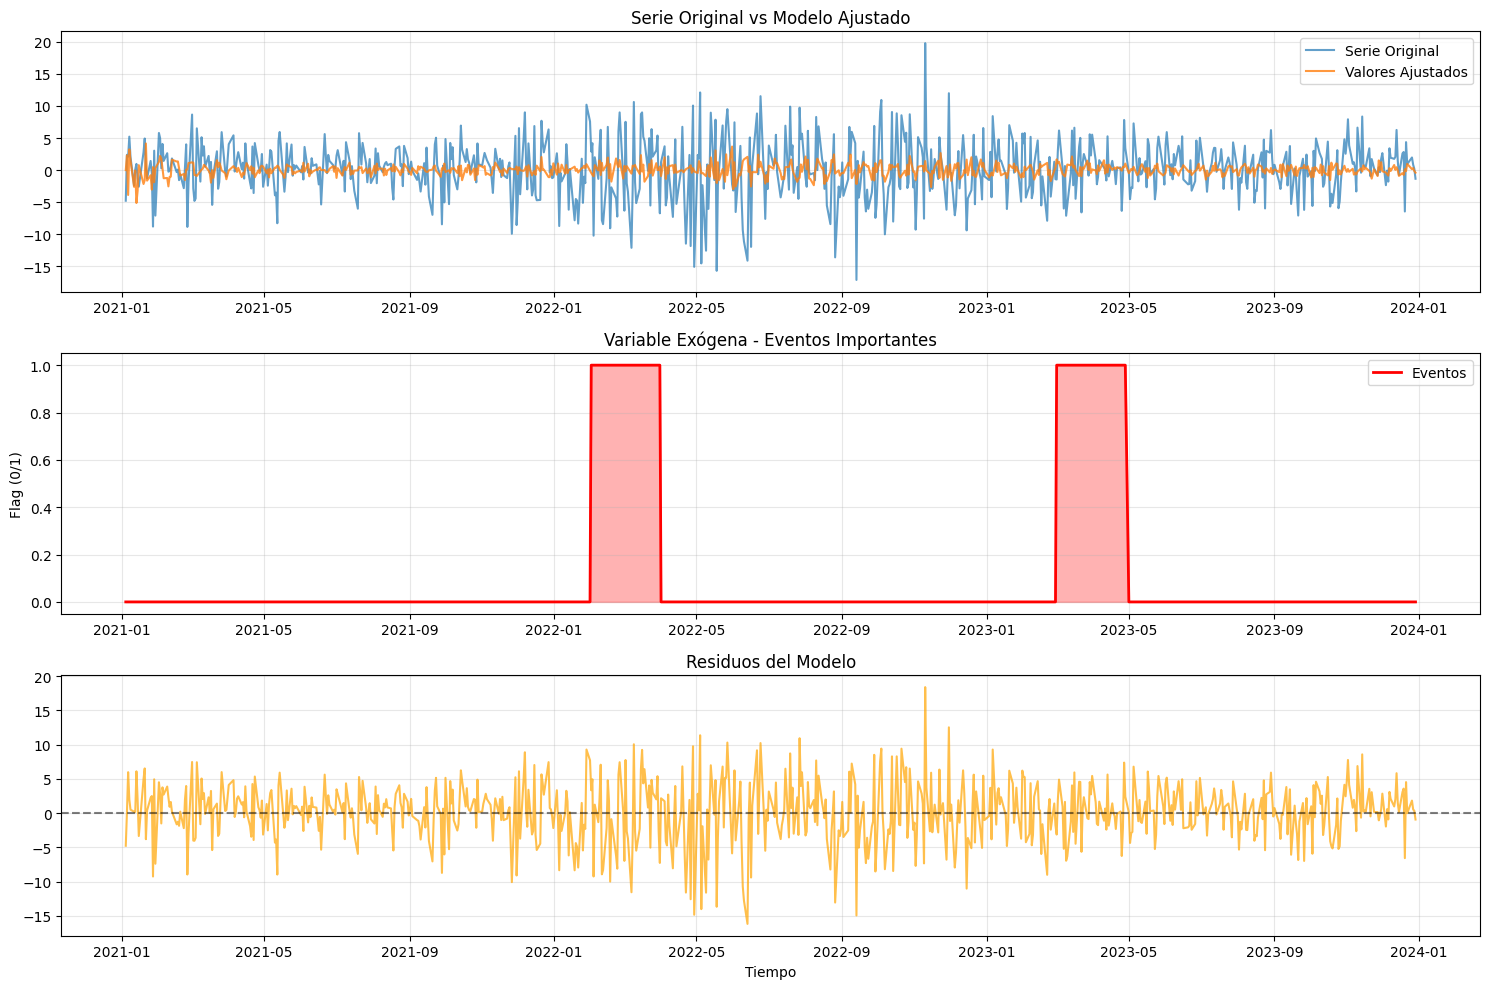


6️⃣ Análisis de coeficientes:
Variable exógena: 0.2764 (p-value: 0.4919) ❌ No significativo


In [23]:
def pipeline_sarimax_corregido(serie, periodos_eventos, nombre_serie="Serie"):
    """
    Pipeline SARIMAX con manejo correcto de zonas horarias
    """
    print(f"🚀 PIPELINE SARIMAX CORREGIDO - {nombre_serie}")
    print("="*60)
    
    try:

        
        # 2. Crear variables exógenas de forma segura
        print("\n2️⃣ Creando variables exógenas...")
        evento_flag, serie_normalizada = crear_variable_exogena_segura(
            serie, periodos_eventos, "evento"
        )
        
        # 3. Verificar que tenemos datos suficientes
        if evento_flag.sum() == 0:
            print("⚠️ No se encontraron eventos en el rango de datos")
            print("Continuando con análisis ARIMA simple...")
            
            # Entrenar ARIMA simple como fallback
            from statsmodels.tsa.arima.model import ARIMA
            modelo_simple = ARIMA(serie_normalizada, order=(1,1,1)).fit()
            
            return modelo_simple, None, None
        
        # 4. Entrenar SARIMAX
        print(f"\n3️⃣ Entrenando modelo SARIMAX...")
        print(f"Variables exógenas: {evento_flag.sum()} eventos de {len(evento_flag)} total")
        
        # Usar SARIMAX sin componente estacional para evitar problemas
        from statsmodels.tsa.statespace.sarimax import SARIMAX
        
        modelo = SARIMAX(
            endog=serie_normalizada,
            exog=evento_flag.values.reshape(-1, 1),
            order=(10, 0, 10),
            seasonal_order=(0, 0, 0, 0),  # Sin estacionalidad
            enforce_stationarity=False,
            enforce_invertibility=False
        )
        
        modelo_ajustado = modelo.fit(disp=False)
        
        print("✅ Modelo SARIMAX entrenado exitosamente")
        print(f"AIC: {modelo_ajustado.aic:.2f}")
        
        # 5. Mostrar resumen
        print("\n4️⃣ Resumen del modelo:")
        print(modelo_ajustado.summary())
        
        # 6. Visualizar ajuste
        print("\n5️⃣ Visualizando resultados...")
        
        plt.figure(figsize=(15, 10))
        
        # Subplot 1: Serie original vs ajustada
        plt.subplot(3, 1, 1)
        plt.plot(serie_normalizada, label='Serie Original', alpha=0.7)
        plt.plot(modelo_ajustado.fittedvalues, label='Valores Ajustados', alpha=0.8)
        plt.title('Serie Original vs Modelo Ajustado')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Subplot 2: Variable exógena
        plt.subplot(3, 1, 2)
        plt.plot(evento_flag, color='red', linewidth=2, label='Eventos')
        plt.fill_between(evento_flag.index, 0, evento_flag, alpha=0.3, color='red')
        plt.title('Variable Exógena - Eventos Importantes')
        plt.ylabel('Flag (0/1)')
        plt.legend()
        plt.grid(True, alpha=0.3)
        
        # Subplot 3: Residuos
        plt.subplot(3, 1, 3)
        residuos = modelo_ajustado.resid
        plt.plot(residuos, color='orange', alpha=0.7)
        plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
        plt.title('Residuos del Modelo')
        plt.xlabel('Tiempo')
        plt.grid(True, alpha=0.3)
        
        plt.tight_layout()
        plt.show()
        
        # 7. Análisis de coeficientes
        print("\n6️⃣ Análisis de coeficientes:")
        params = modelo_ajustado.params
        pvalues = modelo_ajustado.pvalues
        
        for param_name in params.index:
            if 'exog' in param_name or param_name in ['x1', 'exog']:
                coef = params[param_name]
                p_val = pvalues[param_name]
                significativo = "✅ Significativo" if p_val < 0.05 else "❌ No significativo"
                print(f"Variable exógena: {coef:.4f} (p-value: {p_val:.4f}) {significativo}")
        
        return modelo_ajustado, evento_flag, serie_normalizada
        
    except Exception as e:
        print(f"❌ Error en el pipeline: {e}")
        print("Intentando con modelo ARIMA simple...")
        
        # Fallback a ARIMA simple
        try:
            serie_limpia = serie.copy()
            if hasattr(serie_limpia.index, 'tz') and serie_limpia.index.tz is not None:
                serie_limpia.index = serie_limpia.index.tz_localize(None)
            
            from statsmodels.tsa.arima.model import ARIMA
            modelo_fallback = ARIMA(serie_limpia, order=(1,1,1)).fit()
            return modelo_fallback, None, serie_limpia
            
        except Exception as e2:
            print(f"❌ Error también en ARIMA: {e2}")
            return None, None, None

# Ejecutar pipeline corregido
resultado = pipeline_sarimax_corregido(train["2021-01-01":], periodos, "Precio SPY500")
modelo_final, eventos_final, serie_final = resultado

🔧 Creando variable exógena para evento (versión segura)...
Convirtiendo de zona horaria: America/New_York
  ⚠️ Período 1 fuera del rango de datos: 2022-02-01 00:00:00 a 2022-04-01 00:00:00
  ⚠️ Período 2 fuera del rango de datos: 2023-03-01 00:00:00 a 2023-05-01 00:00:00
  ✅ Período 3: 2024-02-01 a 2024-04-01 - 40 puntos
  ✅ Período 4: 2025-02-01 a 2025-04-01 - 40 puntos
✅ Total marcado: 80/426 puntos


<Axes: xlabel='Date', ylabel='Close'>

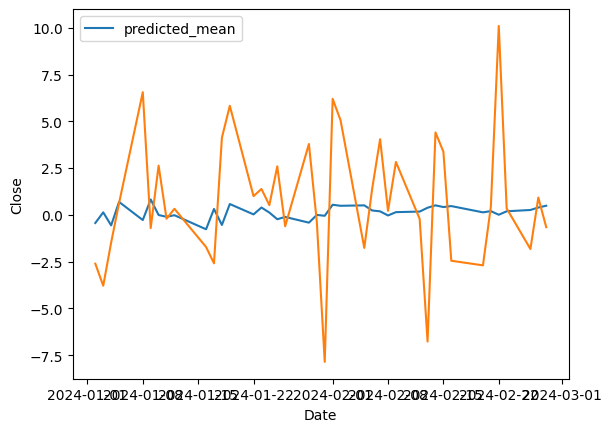

In [24]:
def hacer_predicciones_sarimax(modelo, test, periodos_eventos):
    """
    Hace predicciones con el modelo entrenado
    """
    
    num_periodos = len(test)

    exogenas, serie_normalizada = crear_variable_exogena_segura(
            test, periodos_eventos, "evento"
        )
    
    
    predicciones = modelo.forecast(steps=num_periodos, exog=exogenas)
    conf_int = modelo.get_forecast(steps=num_periodos, exog=exogenas).conf_int()
    
    return predicciones, conf_int

predicciones, conf_int = hacer_predicciones_sarimax(modelo_final, test, periodos)

#forecast = modelo_final.forecast(steps=426)
#conf_int = modelo_final.get_forecast(steps=426).conf_int()

#print(  len(forecast))
#print(len(test))


df_forecast = pd.DataFrame(predicciones)
df_forecast.index = test.index


sns.lineplot(df_forecast.loc[:"2024-02-28"])
sns.lineplot(test.loc[:"2024-02-28"])

In [25]:
!pip3 install prophet scikit-learn plotly
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
import warnings
warnings.filterwarnings('ignore')

# Primero instalar Prophet si no lo tienes:
# pip install prophet

from prophet import Prophet

def preparar_datos_prophet(serie, variables_exogenas=None):
    """
    Prepara los datos en el formato requerido por Prophet
    Prophet requiere columnas 'ds' (fechas) y 'y' (valores)
    """
    print("🔄 Preparando datos para Prophet...")
    
    # Crear DataFrame base para Prophet
    df_prophet = pd.DataFrame({
        'ds': serie.index,
        'y': serie.values
    })
    
    # Agregar variables exógenas si existen
    if variables_exogenas is not None:
        print(f"📊 Agregando {variables_exogenas.shape[1]} variables exógenas...")
        
        # Alinear índices
        fechas_comunes = serie.index.intersection(variables_exogenas.index)
        df_prophet = df_prophet[df_prophet['ds'].isin(fechas_comunes)]
        variables_alineadas = variables_exogenas.loc[fechas_comunes]
        
        # Agregar cada variable exógena
        for col in variables_alineadas.columns:
            df_prophet[col] = variables_alineadas[col].values
            print(f"  ✅ Variable agregada: {col}")
    
    # Asegurar que 'ds' sea datetime sin zona horaria
    df_prophet['ds'] = pd.to_datetime(df_prophet['ds'])
    if df_prophet['ds'].dt.tz is not None:
        df_prophet['ds'] = df_prophet['ds'].dt.tz_localize(None)
    
    print(f"✅ Datos preparados: {len(df_prophet)} observaciones")
    print(f"Columnas: {list(df_prophet.columns)}")
    
    return df_prophet



def entrenar_prophet(df_train, variables_exogenas_nombres=None):
    """
    Entrena modelo Prophet con variables exógenas
    """
    print("🤖 Entrenando modelo Prophet...")
    
    # Crear modelo Prophet
    modelo = Prophet(
        daily_seasonality=False,
        weekly_seasonality=True,
        yearly_seasonality=True,
        changepoint_prior_scale=10,  # Flexibilidad para cambios de tendencia
        seasonality_prior_scale=5,    # Flexibilidad para estacionalidad
        holidays_prior_scale=10,       # Flexibilidad para efectos de holidays
        interval_width=0.95           # Intervalo de confianza 95%
    )
    
    # Agregar variables exógenas como regressors
    if variables_exogenas_nombres is not None:
        for var_name in variables_exogenas_nombres:
            if var_name in df_train.columns:
                modelo.add_regressor(var_name)
                print(f"  ✅ Regressor agregado: {var_name}")
    
    # Entrenar modelo
    modelo.fit(df_train)
    
    print("✅ Modelo Prophet entrenado exitosamente")
    return modelo

def hacer_predicciones_prophet(modelo, df_test):
    """
    Hace predicciones con Prophet
    """
    print(f"🔮 Generando predicciones Prophet para {len(df_test)} períodos...")
    
    # Crear DataFrame futuro con las mismas columnas que el entrenamiento
    future = df_test[['ds']].copy()
    
    # Agregar variables exógenas para el futuro
    for col in df_test.columns:
        if col not in ['ds', 'y']:  # Excluir ds e y
            future[col] = df_test[col].values
    
    # Hacer predicciones
    forecast = modelo.predict(future)
    
    print("✅ Predicciones generadas")
    return forecast

^C


ModuleNotFoundError: No module named 'sklearn'

  Using cached scikit_learn-1.7.2-cp313-cp313-win_amd64.whl.metadata (11 kB)
  Using cached joblib-1.5.2-py3-none-any.whl.metadata (5.6 kB)
  Using cached threadpoolctl-3.6.0-py3-none-any.whl.metadata (13 kB)
   ---------------------------------------- 0.0/13.3 MB ? eta -:--:--
   -- ------------------------------------- 0.8/13.3 MB 4.1 MB/s eta 0:00:04
   ---- ----------------------------------- 1.6/13.3 MB 4.2 MB/s eta 0:00:03
   ------ --------------------------------- 2.1/13.3 MB 3.8 MB/s eta 0:00:03
   ------- -------------------------------- 2.6/13.3 MB 3.1 MB/s eta 0:00:04
   --------- ------------------------------ 3.1/13.3 MB 3.2 MB/s eta 0:00:04
   ----------- ---------------------------- 3.9/13.3 MB 3.2 MB/s eta 0:00:03
   -------------- ------------------------- 5.0/13.3 MB 3.3 MB/s eta 0:00:03
   ----------------- ---------------------- 5.8/13.3 MB 3.4 MB/s eta 0:00:03
   ------------------- -------------------- 6.6/13.3 MB 3.5 MB/s eta 0:00:02
   --------------------- ---


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


In [ ]:
periodos_eventos = [
    ['2022-02-01', "2022-04-01"],
    ["2023-03-01", "2023-05-01"],
    ["2024-02-01", "2024-04-01"],
]

# Usar tu función crear_variable_exogena_segura
evento_flag, ts_limpio = crear_variable_exogena_segura(ts, periodos_eventos, "evento_importante")

df_prophet = preparar_datos_prophet(ts_limpio, evento_flag.to_frame())
train = df_prophet.loc[df_prophet["ds"]<="2023-12-31"]
test = df_prophet.loc[df_prophet["ds"]>"2023-12-31"]

modelo_prophet = entrenar_prophet(train, ["evento_importante_flag"])

predicciones = hacer_predicciones_prophet(modelo_prophet, test)



In [ ]:
predicciones = hacer_predicciones_prophet(modelo_prophet, train)
predicciones

In [ ]:
sns.lineplot(data = predicciones, x = "ds", y = "yhat")
sns.lineplot(data = train, x = "ds", y = "y")


In [ ]:
import pandas as pd
import numpy as np

def crear_variables_lag(serie, lags=None, prefijo='lag'):
    """
    Crea variables lag de forma dinámica evitando data leakage
    
    Parameters:
    serie: Serie de tiempo
    lags: Lista de lags a crear o entero para crear lags 1 hasta n
    prefijo: Prefijo para nombrar las columnas
    
    Returns:
    DataFrame con variables lag
    """
    if lags is None:
        lags = [1, 2, 3, 5, 10]  # Default lags
    elif isinstance(lags, int):
        lags = list(range(1, lags + 1))  # Crear lags de 1 hasta n
    
    print(f"🔄 Creando variables lag: {lags}")
    
    # Crear DataFrame resultado
    df_lags = pd.DataFrame(index=serie.index)
    
    for lag in lags:
        # Importante: shift(lag) usa valores PASADOS (evita data leakage)
        df_lags[f'{prefijo}_{lag}'] = serie.shift(lag)
        print(f"  ✅ {prefijo}_{lag} creado (datos {lag} períodos atrás)")
    
    # Mostrar información sobre valores nulos
    valores_nulos = df_lags.isnull().sum()
    print(f"\n📊 Valores nulos por variable:")
    for col, nulos in valores_nulos.items():
        print(f"  {col}: {nulos} valores nulos (normal para los primeros {col.split('_')[1]} registros)")
    
    return df_lags

def crear_promedios_moviles(serie, ventanas=None, prefijo='ma'):
    """
    Crea promedios móviles de n períodos anteriores (evita data leakage)
    
    Parameters:
    serie: Serie de tiempo
    ventanas: Lista de ventanas o entero para ventanas 2 hasta n
    prefijo: Prefijo para nombrar las columnas
    
    Returns:
    DataFrame con promedios móviles
    """
    if ventanas is None:
        ventanas = [3, 5, 10, 20, 50]  # Default ventanas
    elif isinstance(ventanas, int):
        ventanas = list(range(2, ventanas + 1))  # Crear ventanas de 2 hasta n
    
    print(f"📊 Creando promedios móviles: {ventanas}")
    
    # Crear DataFrame resultado
    df_ma = pd.DataFrame(index=serie.index)
    
    for ventana in ventanas:
        # CRÍTICO: usar shift(1) para evitar data leakage
        # Calcula promedio de los últimos n períodos ANTERIORES al actual
        df_ma[f'{prefijo}_{ventana}'] = serie.shift(1).rolling(
            window=ventana, 
            min_periods=ventana
        ).mean()
        
        print(f"  ✅ {prefijo}_{ventana} creado (promedio de {ventana} períodos anteriores)")
    
    # Información sobre valores nulos
    valores_nulos = df_ma.isnull().sum()
    print(f"\n📊 Valores nulos por variable:")
    for col, nulos in valores_nulos.items():
        ventana_size = int(col.split('_')[1])
        print(f"  {col}: {nulos} valores nulos (normal para los primeros {ventana_size} registros)")
    
    return df_ma

def crear_std_moviles(serie, ventanas=None, prefijo='std'):
    """
    Crea desviaciones estándar móviles de n períodos anteriores (evita data leakage)
    
    Parameters:
    serie: Serie de tiempo
    ventanas: Lista de ventanas o entero para ventanas 2 hasta n
    prefijo: Prefijo para nombrar las columnas
    
    Returns:
    DataFrame con desviaciones estándar móviles
    """
    if ventanas is None:
        ventanas = [3, 5, 10, 20, 50]  # Default ventanas
    elif isinstance(ventanas, int):
        ventanas = list(range(2, ventanas + 1))  # Crear ventanas de 2 hasta n
    
    print(f"📈 Creando desviaciones estándar móviles: {ventanas}")
    
    # Crear DataFrame resultado
    df_std = pd.DataFrame(index=serie.index)
    
    for ventana in ventanas:
        # CRÍTICO: usar shift(1) para evitar data leakage
        # Calcula std de los últimos n períodos ANTERIORES al actual
        df_std[f'{prefijo}_{ventana}'] = serie.shift(1).rolling(
            window=ventana, 
            min_periods=ventana
        ).std()
        
        print(f"  ✅ {prefijo}_{ventana} creado (std de {ventana} períodos anteriores)")
    
    # Información sobre valores nulos
    valores_nulos = df_std.isnull().sum()
    print(f"\n📊 Valores nulos por variable:")
    for col, nulos in valores_nulos.items():
        ventana_size = int(col.split('_')[1])
        print(f"  {col}: {nulos} valores nulos (normal para los primeros {ventana_size} registros)")
    
    return df_std

def crear_variables_rolling_avanzadas(serie, ventanas=None, prefijo='roll'):
    """
    Crea variables rolling avanzadas (min, max, mediana) evitando data leakage
    """
    if ventanas is None:
        ventanas = [5, 10, 20]
    elif isinstance(ventanas, int):
        ventanas = list(range(2, ventanas + 1))
    
    print(f"🔧 Creando variables rolling avanzadas: {ventanas}")
    
    df_roll = pd.DataFrame(index=serie.index)
    
    for ventana in ventanas:
        # Todos usan shift(1) para evitar data leakage
        rolling_data = serie.shift(1).rolling(window=ventana, min_periods=ventana)
        
        df_roll[f'{prefijo}_min_{ventana}'] = rolling_data.min()
        df_roll[f'{prefijo}_max_{ventana}'] = rolling_data.max()
        df_roll[f'{prefijo}_median_{ventana}'] = rolling_data.median()
        df_roll[f'{prefijo}_q25_{ventana}'] = rolling_data.quantile(0.25)
        df_roll[f'{prefijo}_q75_{ventana}'] = rolling_data.quantile(0.75)
        
        print(f"  ✅ Variables rolling {ventana} creadas (min, max, median, q25, q75)")
    
    return df_roll

def crear_variables_tecnicas(serie, ventanas_cortas=None, ventanas_largas=None):
    """
    Crea variables técnicas comunes evitando data leakage
    """
    if ventanas_cortas is None:
        ventanas_cortas = [5, 10, 20]
    if ventanas_largas is None:
        ventanas_largas = [50, 100, 200]
    
    print(f"📈 Creando variables técnicas...")
    
    df_tech = pd.DataFrame(index=serie.index)
    
    # RSI (Relative Strength Index) - usando datos pasados
    for ventana in [14, 30]:
        delta = serie.diff()
        gain = (delta.where(delta > 0, 0)).shift(1).rolling(window=ventana).mean()
        loss = (-delta.where(delta < 0, 0)).shift(1).rolling(window=ventana).mean()
        rs = gain / loss
        df_tech[f'rsi_{ventana}'] = 100 - (100 / (1 + rs))
        print(f"  ✅ RSI_{ventana} creado")
    
    # Bandas de Bollinger
    for ventana in ventanas_cortas:
        ma = serie.shift(1).rolling(window=ventana).mean()
        std = serie.shift(1).rolling(window=ventana).std()
        df_tech[f'bb_upper_{ventana}'] = ma + (2 * std)
        df_tech[f'bb_lower_{ventana}'] = ma - (2 * std)
        df_tech[f'bb_width_{ventana}'] = df_tech[f'bb_upper_{ventana}'] - df_tech[f'bb_lower_{ventana}']
        print(f"  ✅ Bandas Bollinger {ventana} creadas")
    
    # MACD (Moving Average Convergence Divergence)
    ema12 = serie.shift(1).ewm(span=12).mean()
    ema26 = serie.shift(1).ewm(span=26).mean()
    df_tech['macd'] = ema12 - ema26
    df_tech['macd_signal'] = df_tech['macd'].shift(1).ewm(span=9).mean()
    df_tech['macd_histogram'] = df_tech['macd'] - df_tech['macd_signal']
    print(f"  ✅ MACD creado")
    
    return df_tech

def crear_features_completas(serie, config=None):
    """
    Función principal que crea todas las features evitando data leakage
    
    Parameters:
    serie: Serie de tiempo
    config: Diccionario con configuración personalizada
    """
    if config is None:
        config = {
            'lags': [1, 2, 3, 5, 10, 20],
            'ventanas_ma': [3, 5, 10, 20, 50],
            'ventanas_std': [5, 10, 20],
            'ventanas_rolling': [5, 10, 20],
            'incluir_tecnicas': True
        }
    
    print("🚀 CREANDO FEATURES COMPLETAS")
    print("="*50)
    
    # Normalizar zona horaria
    if hasattr(serie.index, 'tz') and serie.index.tz is not None:
        serie = serie.copy()
        serie.index = serie.index.tz_localize(None)
        print("✅ Zona horaria normalizada")
    
    # Crear todas las variables
    features_completas = pd.DataFrame(index=serie.index)
    
    # 1. Variables lag
    print("\n1️⃣ Creando variables lag...")
    df_lags = crear_variables_lag(serie, config['lags'])
    features_completas = pd.concat([features_completas, df_lags], axis=1)
    
    # 2. Promedios móviles
    print("\n2️⃣ Creando promedios móviles...")
    df_ma = crear_promedios_moviles(serie, config['ventanas_ma'])
    features_completas = pd.concat([features_completas, df_ma], axis=1)
    
    # 3. Desviaciones estándar móviles
    print("\n3️⃣ Creando desviaciones estándar móviles...")
    df_std = crear_std_moviles(serie, config['ventanas_std'])
    features_completas = pd.concat([features_completas, df_std], axis=1)
    
    # 4. Variables rolling avanzadas
    print("\n4️⃣ Creando variables rolling avanzadas...")
    df_roll = crear_variables_rolling_avanzadas(serie, config['ventanas_rolling'])
    features_completas = pd.concat([features_completas, df_roll], axis=1)
    
    # 5. Variables técnicas
    if config['incluir_tecnicas']:
        print("\n5️⃣ Creando variables técnicas...")
        df_tech = crear_variables_tecnicas(serie)
        features_completas = pd.concat([features_completas, df_tech], axis=1)
    
    # 6. Variable objetivo (valor actual)
    features_completas['target'] = serie
    
    # 7. Resumen final
    print(f"\n📊 RESUMEN FINAL:")
    print(f"  Total features creadas: {len(features_completas.columns) - 1}")  # -1 por target
    print(f"  Total observaciones: {len(features_completas)}")
    print(f"  Rango de fechas: {features_completas.index.min()} a {features_completas.index.max()}")
    
    # Información sobre valores nulos
    valores_nulos = features_completas.isnull().sum()
    features_con_nulos = valores_nulos[valores_nulos > 0]
    
    if len(features_con_nulos) > 0:
        print(f"\n⚠️  Variables con valores nulos:")
        for var, nulos in features_con_nulos.items():
            print(f"  {var}: {nulos} valores nulos")
        
        # Eliminar filas con muchos nulos (primeras filas típicamente)
        max_lag = max(config['lags']) if config['lags'] else 0
        max_ventana = max(config['ventanas_ma'] + config['ventanas_std'] + config['ventanas_rolling'])
        min_observaciones_validas = max(max_lag, max_ventana)
        
        print(f"\n🧹 Recomendación: Eliminar las primeras {min_observaciones_validas} filas")
        features_limpias = features_completas.iloc[min_observaciones_validas:].copy()
        print(f"✅ Dataset limpio: {len(features_limpias)} observaciones")
        
        return features_limpias
    
    return features_completas

def verificar_no_data_leakage(features, target_col='target', mostrar_ejemplo=True):
    """
    Verifica que no hay data leakage en las features creadas
    """
    print("🔍 VERIFICACIÓN DE DATA LEAKAGE")
    print("="*40)
    
    # Seleccionar una fecha random para verificar
    if mostrar_ejemplo and len(features) > 100:
        idx_random = np.random.randint(50, len(features) - 10)
        fecha_ejemplo = features.index[idx_random]
        
        print(f"📅 Verificando fecha ejemplo: {fecha_ejemplo}")
        print(f"Valor target en esa fecha: {features.loc[fecha_ejemplo, target_col]:.4f}")
        
        print(f"\n🔍 Verificando que las features usan solo datos ANTERIORES:")
        
        # Verificar algunas variables lag
        lag_cols = [col for col in features.columns if 'lag_' in col][:3]
        for col in lag_cols:
            lag_num = int(col.split('_')[1])
            fecha_anterior = features.index[idx_random - lag_num]
            valor_lag = features.loc[fecha_ejemplo, col]
            valor_real_anterior = features.loc[fecha_anterior, target_col]
            
            print(f"  {col}: {valor_lag:.4f} == valor real {lag_num} períodos antes: {valor_real_anterior:.4f}")
            assert abs(valor_lag - valor_real_anterior) < 1e-6, f"Data leakage en {col}!"
        
        # Verificar promedio móvil
        ma_cols = [col for col in features.columns if 'ma_' in col][:2]
        for col in ma_cols:
            ventana = int(col.split('_')[1])
            fecha_inicio = idx_random - ventana
            fecha_fin = idx_random - 1  # No incluir el día actual
            
            valores_anteriores = features.loc[features.index[fecha_inicio:fecha_fin+1], target_col]
            ma_calculado = valores_anteriores.mean()
            ma_feature = features.loc[fecha_ejemplo, col]
            
            print(f"  {col}: {ma_feature:.4f} == promedio calculado: {ma_calculado:.4f}")
            assert abs(ma_feature - ma_calculado) < 1e-4, f"Data leakage en {col}!"
        
        print("✅ No se detectó data leakage - Las features usan solo datos pasados")
    
    else:
        print("⚠️  No hay suficientes datos para verificación completa")

In [ ]:
# Haciendolo en modelos de machine learning
# Creando nuestro dataset

# Ejemplo con tu dataset
# Supongamos que tu serie se llama 'ts'

# Configuración personalizada
config_personalizada = {
    'lags': [1, 2, 3, 4, 5, 6,7,8,9, 10,11,12,13,14,15,16,17,18,19,20, 50,60,90,120,180,240,360],  # Lags que quieres
    'ventanas_ma': [5, 10, 20, 50, 100],  # Ventanas para promedios móviles
    'ventanas_std': [5, 10, 20, 50],  # Ventanas para std móvil
    'ventanas_rolling': [10, 20, 50],  # Ventanas para min/max/median
    'incluir_tecnicas': True  # Incluir RSI, MACD, Bollinger
}

# Crear todas las features
features_dataset = crear_features_completas(ts, config_personalizada)

# Verificar que no hay data leakage
verificar_no_data_leakage(features_dataset)

In [ ]:
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

def crear_variables_fechas_basicas(serie):
    """
    Crea variables básicas de fechas
    """
    print("📅 Creando variables básicas de fechas...")
    
    # Normalizar zona horaria
    if hasattr(serie.index, 'tz') and serie.index.tz is not None:
        serie = serie.copy()
        serie.index = serie.index.tz_localize(None)
    
    #df_fechas = pd.DataFrame(index=serie.index)
    df_fechas = serie.copy()
    
    # Variables básicas
    df_fechas['año'] = serie.index.year
    df_fechas['mes'] = serie.index.month
    df_fechas['dia'] = serie.index.day
    df_fechas['dia_semana'] = serie.index.dayofweek  # 0=Lunes, 6=Domingo
    df_fechas['dia_año'] = serie.index.dayofyear
    df_fechas['semana_año'] = serie.index.isocalendar().week
    df_fechas['trimestre'] = serie.index.quarter
    
    # Variables categóricas útiles
    df_fechas['es_fin_semana'] = (serie.index.dayofweek >= 5).astype(int)
    df_fechas['es_lunes'] = (serie.index.dayofweek == 0).astype(int)
    df_fechas['es_viernes'] = (serie.index.dayofweek == 4).astype(int)
    
    # Variables cíclicas (útiles para ML)
    df_fechas['mes_sin'] = np.sin(2 * np.pi * serie.index.month / 12)
    df_fechas['mes_cos'] = np.cos(2 * np.pi * serie.index.month / 12)
    df_fechas['dia_semana_sin'] = np.sin(2 * np.pi * serie.index.dayofweek / 7)
    df_fechas['dia_semana_cos'] = np.cos(2 * np.pi * serie.index.dayofweek / 7)
    
    print(f"✅ Variables básicas creadas: {len(df_fechas.columns)} variables")
    return df_fechas

def calcular_distancia_navidad(fecha):
    """
    Calcula las semanas que faltan para la próxima Navidad
    """
    año_actual = fecha.year
    navidad_este_año = datetime(año_actual, 12, 25)
    
    # Si ya pasó Navidad este año, calcular para el próximo
    if fecha > navidad_este_año:
        navidad_proxima = datetime(año_actual + 1, 12, 25)
    else:
        navidad_proxima = navidad_este_año
    
    dias_diferencia = (navidad_proxima - fecha).days
    semanas_diferencia = dias_diferencia / 7
    
    return semanas_diferencia

def calcular_distancia_año_nuevo(fecha):
    """
    Calcula las semanas que faltan para el próximo Año Nuevo
    """
    año_siguiente = fecha.year + 1
    año_nuevo = datetime(año_siguiente, 1, 1)
    
    dias_diferencia = (año_nuevo - fecha).days
    semanas_diferencia = dias_diferencia / 7
    
    return semanas_diferencia

def crear_variables_fechas_especiales(serie):
    """
    Crea variables relacionadas con fechas especiales y festividades
    """
    print("🎄 Creando variables de fechas especiales...")
    
    # Normalizar zona horaria
    if hasattr(serie.index, 'tz') and serie.index.tz is not None:
        serie = serie.copy()
        serie.index = serie.index.tz_localize(None)
    
    df_especiales = serie.copy()
    
    # Distancias a festividades importantes
    df_especiales['semanas_hasta_navidad'] = [
        calcular_distancia_navidad(fecha) for fecha in serie.index
    ]
    
    df_especiales['semanas_hasta_año_nuevo'] = [
        calcular_distancia_año_nuevo(fecha) for fecha in serie.index
    ]
    
    # Períodos especiales del año
    df_especiales['es_diciembre'] = (serie.index.month == 12).astype(int)
    df_especiales['es_enero'] = (serie.index.month == 1).astype(int)
    df_especiales['es_q4'] = (serie.index.quarter == 4).astype(int)
    df_especiales['es_q1'] = (serie.index.quarter == 1).astype(int)
    
    # Temporada navideña (noviembre-diciembre)
    df_especiales['temporada_navidena'] = (
        (serie.index.month == 11) | (serie.index.month == 12)
    ).astype(int)
    
    # Black Friday (4to viernes de noviembre - aproximación)
    df_especiales['cerca_black_friday'] = 0
    for i, fecha in enumerate(serie.index):
        if fecha.month == 11:
            # Encontrar el 4to viernes de noviembre
            primer_dia = datetime(fecha.year, 11, 1)
            dias_hasta_viernes = (4 - primer_dia.weekday()) % 7
            primer_viernes = primer_dia + timedelta(days=dias_hasta_viernes)
            cuarto_viernes = primer_viernes + timedelta(days=21)  # 3 semanas después
            
            # Marcar la semana del Black Friday
            if abs((fecha - cuarto_viernes).days) <= 3:
                df_especiales.iloc[i, df_especiales.columns.get_loc('cerca_black_friday')] = 1
    
    # Inicio/fin de año fiscal (para acciones)
    df_especiales['fin_año_fiscal'] = (
        (serie.index.month == 12) & (serie.index.day >= 25)
    ).astype(int)
    
    df_especiales['inicio_año_fiscal'] = (
        (serie.index.month == 1) & (serie.index.day <= 10)
    ).astype(int)
    
    print(f"✅ Variables especiales creadas: {len(df_especiales.columns)} variables")
    return df_especiales

def crear_variables_estacionales(serie):
    """
    Crea variables estacionales más sofisticadas
    """
    print("🌸 Creando variables estacionales...")
    
    # Normalizar zona horaria
    if hasattr(serie.index, 'tz') and serie.index.tz is not None:
        serie = serie.copy()
        serie.index = serie.index.tz_localize(None)
    
    df_estacional = serie.copy()
    
    # Estaciones del año (hemisferio norte)
    def obtener_estacion(fecha):
        mes = fecha.month
        if mes in [12, 1, 2]:
            return 'invierno'
        elif mes in [3, 4, 5]:
            return 'primavera'
        elif mes in [6, 7, 8]:
            return 'verano'
        else:
            return 'otoño'
    
    estaciones = [obtener_estacion(fecha) for fecha in serie.index]
    
    # One-hot encoding para estaciones
    df_estacional['es_invierno'] = (pd.Series(estaciones, index=serie.index) == 'invierno').astype(int)
    df_estacional['es_primavera'] = (pd.Series(estaciones, index=serie.index) == 'primavera').astype(int)
    df_estacional['es_verano'] = (pd.Series(estaciones, index=serie.index) == 'verano').astype(int)
    df_estacional['es_otoño'] = (pd.Series(estaciones, index=serie.index) == 'otoño').astype(int)
    
    # Variables de intensidad estacional (cíclicas)
    dia_año_normalizado = serie.index.dayofyear / 365.25
    df_estacional['estacion_sin'] = np.sin(2 * np.pi * dia_año_normalizado)
    df_estacional['estacion_cos'] = np.cos(2 * np.pi * dia_año_normalizado)
    
    # Patrones bimestrales y trimestrales
    df_estacional['bimestre'] = ((serie.index.month - 1) // 2) + 1
    df_estacional['bimestre_sin'] = np.sin(2 * np.pi * df_estacional['bimestre'] / 6)
    df_estacional['bimestre_cos'] = np.cos(2 * np.pi * df_estacional['bimestre'] / 6)
    
    print(f"✅ Variables estacionales creadas: {len(df_estacional.columns)} variables")
    return df_estacional

def crear_variables_mercado_financiero(serie):
    """
    Crea variables específicas para mercados financieros
    """
    print("📈 Creando variables específicas de mercados financieros...")
    
    # Normalizar zona horaria
    if hasattr(serie.index, 'tz') and serie.index.tz is not None:
        serie = serie.copy()
        serie.index = serie.index.tz_localize(None)
    
    df_mercado = serie.copy()
    
    # Días de la semana específicos para trading
    df_mercado['es_lunes_trading'] = (serie.index.dayofweek == 0).astype(int)  # Efecto lunes
    df_mercado['es_viernes_trading'] = (serie.index.dayofweek == 4).astype(int)  # Efecto viernes
    
    # Efectos de fin de mes/trimestre/año
    def es_ultimo_dia_mes(fecha):
        siguiente_mes = fecha + timedelta(days=1)
        return siguiente_mes.month != fecha.month
    
    def es_ultimo_dia_trimestre(fecha):
        return fecha.month in [3, 6, 9, 12] and es_ultimo_dia_mes(fecha)
    
    df_mercado['fin_de_mes'] = [es_ultimo_dia_mes(fecha) for fecha in serie.index]
    df_mercado['fin_de_trimestre'] = [es_ultimo_dia_trimestre(fecha) for fecha in serie.index]
    
    # Primeros días del mes (efecto rebalanceo)
    df_mercado['primeros_5_dias_mes'] = (serie.index.day <= 5).astype(int)
    df_mercado['ultimos_5_dias_mes'] = [
        es_ultimo_dia_mes(fecha + timedelta(days=4)) for fecha in serie.index
    ]
    
    # Períodos de earnings (trimestres)
    df_mercado['periodo_earnings'] = (
        ((serie.index.month == 1) & (serie.index.day <= 31)) |  # Q4 earnings
        ((serie.index.month == 4) & (serie.index.day <= 30)) |  # Q1 earnings
        ((serie.index.month == 7) & (serie.index.day <= 31)) |  # Q2 earnings
        ((serie.index.month == 10) & (serie.index.day <= 31))   # Q3 earnings
    ).astype(int)
    
    # Días festivos bursátiles importantes (aproximados)
    def es_cerca_festivo_bursatil(fecha):
        # Año nuevo, Memorial Day, Independence Day, Labor Day, Thanksgiving, Christmas
        festivos_fijos = [
            (1, 1),   # Año nuevo
            (7, 4),   # Independence Day
            (12, 25), # Christmas
        ]
        
        for mes, dia in festivos_fijos:
            festivo = datetime(fecha.year, mes, dia)
            if abs((fecha - festivo).days) <= 1:  # 1 día antes/después
                return True
        
        return False
    
    df_mercado['cerca_festivo_bursatil'] = [
        es_cerca_festivo_bursatil(fecha) for fecha in serie.index
    ]
    
    print(f"✅ Variables de mercado creadas: {len(df_mercado.columns)} variables")
    return df_mercado

def crear_todas_variables_fechas(serie, incluir_mercado=True):
    """
    Función principal que crea todas las variables de fechas
    """
    print("🚀 CREANDO TODAS LAS VARIABLES DE FECHAS")
    print("="*60)
    
    # Normalizar zona horaria
    if hasattr(serie.index, 'tz') and serie.index.tz is not None:
        serie = serie.copy()
        serie.index = serie.index.tz_localize(None)
    
    # Crear todas las variables
    variables_fechas = serie.copy()
    
    # 1. Variables básicas
    print("\n1️⃣ Variables básicas...")
    df_basicas = crear_variables_fechas_basicas(serie)
    variables_fechas = pd.concat([variables_fechas, df_basicas], axis=1)
    
    # 2. Variables especiales
    print("\n2️⃣ Variables especiales...")
    df_especiales = crear_variables_fechas_especiales(serie)
    variables_fechas = pd.concat([variables_fechas, df_especiales], axis=1)
    
    # 3. Variables estacionales
    print("\n3️⃣ Variables estacionales...")
    df_estacionales = crear_variables_estacionales(serie)
    variables_fechas = pd.concat([variables_fechas, df_estacionales], axis=1)
    
    # 4. Variables de mercado (opcional)
    if incluir_mercado:
        print("\n4️⃣ Variables de mercado financiero...")
        df_mercado = crear_variables_mercado_financiero(serie)
        variables_fechas = pd.concat([variables_fechas, df_mercado], axis=1)
    
    # Resumen final
    print(f"\n📊 RESUMEN FINAL:")
    print(f"  Total variables de fechas creadas: {len(variables_fechas.columns)}")
    print(f"  Observaciones: {len(variables_fechas)}")
    
    # Mostrar algunas variables de ejemplo
    print(f"\n📅 Variables creadas:")
    for i, col in enumerate(variables_fechas.columns):
        if i < 10:  # Mostrar primeras 10
            print(f"  ✅ {col}")
        elif i == 10:
            print(f"  ... y {len(variables_fechas.columns) - 10} más")
            break
    
    return variables_fechas

In [ ]:
dataset_final = crear_todas_variables_fechas(features_dataset)

In [ ]:
dataset_final = dataset_final.T.drop_duplicates().T

In [ ]:
# Agregar las predicciones de Prophet como variable

periodos_eventos = [
    ['2022-02-01', "2022-04-01"],
    ["2023-03-01", "2023-05-01"],
    ["2024-02-01", "2024-04-01"],
]

# Usar tu función crear_variable_exogena_segura
evento_flag, ts_limpio = crear_variable_exogena_segura(ts, periodos_eventos, "evento_importante")

df_prophet = preparar_datos_prophet(ts_limpio, evento_flag.to_frame())
train_prophet = df_prophet.loc[df_prophet["ds"]<="2023-12-31"]
test_prophet = df_prophet.loc[df_prophet["ds"]>"2023-12-31"]

modelo_prophet = entrenar_prophet(train_prophet, ["evento_importante_flag"])

predicciones_test = hacer_predicciones_prophet(modelo_prophet, test_prophet)
predicciones_train = hacer_predicciones_prophet(modelo_prophet, train_prophet)


In [ ]:
df_prophet = pd.concat([predicciones_train, predicciones_test])
df_prophet = df_prophet[["ds","yhat"]]
df_prophet = df_prophet.rename(columns={"ds":"Date"})
df_prophet["Date"] = pd.to_datetime(df_prophet["Date"].dt.date)
dataset_final_no_index = dataset_final.reset_index()
dataset_final_no_index = pd.merge(dataset_final_no_index, df_prophet, on="Date", how="left")
dataset_final_no_index.set_index("Date", inplace=True)

In [ ]:
def calcular_momentum_simple(serie, ventanas=None, prefijo='momentum'):
    """
    Calcula momentum simple (cambio porcentual) para diferentes ventanas
    
    Parameters:
    serie: Serie de tiempo
    ventanas: Lista de ventanas temporales
    prefijo: Prefijo para nombrar columnas
    """
    if ventanas is None:
        ventanas = [1, 2, 3, 5, 10, 20]
    
    print(f"📈 Calculando momentum simple para ventanas: {ventanas}")
    serie_ = serie["target"]
    df_momentum = serie.copy()
    #df_momentum = df_momentum[["target"]]
    for ventana in ventanas:
        # Momentum = (valor_actual - valor_anterior) / valor_anterior
        df_momentum[f'{prefijo}_{ventana}'] = serie_.pct_change(ventana)
        
        # Momentum absoluto (cambio en puntos)
        df_momentum[f'{prefijo}_abs_{ventana}'] = serie_.diff(ventana)
        
        print(f"  ✅ Momentum {ventana} períodos creado")
    
    return df_momentum

In [ ]:
dataset_final_no_index

In [ ]:
dataset_final_no_index = calcular_momentum_simple(dataset_final_no_index)

In [ ]:
from scipy import stats
import pandas as pd
import numpy as np
def calcular_velocidad_momentum_corregida(serie, ventanas=None, metodo='lineal', columna_target='target'):
    """
    Calcula velocidad usando regresión lineal sobre n períodos anteriores
    
    Parameters:
    serie: Serie de tiempo o DataFrame
    ventanas: Lista de ventanas para calcular velocidad
    metodo: 'lineal', 'polinomial', 'log'
    columna_target: Nombre de la columna objetivo si serie es DataFrame
    """
    if ventanas is None:
        ventanas = [3, 5, 10, 20]
    
    print(f"🚀 Calculando velocidad momentum (método: {metodo}) para ventanas: {ventanas}")
    
    # CORRECCIÓN 1: Manejar tanto Series como DataFrames
    if isinstance(serie, pd.DataFrame):
        if columna_target not in serie.columns:
            raise ValueError(f"Columna '{columna_target}' no encontrada. Columnas disponibles: {list(serie.columns)}")
        serie_valores = serie[columna_target]
        indice_original = serie.index
    else:
        serie_valores = serie
        indice_original = serie.index
    
    print(f"📊 Procesando serie con {len(serie_valores)} valores")
    
    # CORRECCIÓN 2: Crear DataFrame resultado con el índice correcto
    df_velocidad = pd.DataFrame(index=indice_original)
    
    for ventana in ventanas:
        print(f"\n🔄 Procesando ventana {ventana}...")
        velocidades = []
        
        for i in range(len(serie_valores)):
            if i < ventana:
                velocidades.append(np.nan)
            else:
                # Tomar los últimos n valores
                y_values = serie_valores.iloc[i-ventana+1:i+1].values
                x_values = np.arange(ventana)
                
                # Verificar que no hay NaNs o infinitos
                
                
                
                try:
                    if metodo == 'lineal':
                        # Regresión lineal: pendiente = velocidad
                        if len(y_values) > 1:
                            slope, intercept, r_value, p_value, std_err = stats.linregress(x_values, y_values)
                            velocidades.append(slope)
                        else:
                            velocidades.append(np.nan)
                            
                    elif metodo == 'polinomial':
                        # Ajuste polinomial de grado 2
                        if len(y_values) > 2:
                            coefs = np.polyfit(x_values, y_values, 2)
                            # La derivada de ax²+bx+c es 2ax+b
                            # En el punto final: velocidad = 2*a*(ventana-1) + b
                            velocidad = 2 * coefs[0] * (ventana-1) + coefs[1]
                            velocidades.append(velocidad)
                        else:
                            velocidades.append(np.nan)
                            
                    elif metodo == 'log':
                        # Cambio logarítmico (para series con crecimiento exponencial)
                        if len(y_values) > 1 and np.all(y_values > 0):
                            # CORRECCIÓN 3: Verificación más robusta para valores positivos
                            log_values = np.log(y_values)
                            slope, _, _, _, _ = stats.linregress(x_values, log_values)
                            velocidades.append(slope)
                        else:
                            velocidades.append(np.nan)
                            
                except Exception as e:
                    print(f"⚠️ Error en ventana {ventana}, posición {i}: {e}")
                    velocidades.append(np.nan)
        
        # CORRECCIÓN 4: Verificar que las longitudes coinciden
        if len(velocidades) != len(df_velocidad):
            print(f"❌ Error: longitud de velocidades ({len(velocidades)}) != longitud del DataFrame ({len(df_velocidad)})")
            # Ajustar longitud si es necesario
            if len(velocidades) < len(df_velocidad):
                velocidades.extend([np.nan] * (len(df_velocidad) - len(velocidades)))
            else:
                velocidades = velocidades[:len(df_velocidad)]
        
        df_velocidad[f'velocidad_{metodo}_{ventana}'] = velocidades
        valores_validos = pd.Series(velocidades).notna().sum()
        print(f"  ✅ Velocidad {metodo} {ventana} períodos creada - {valores_validos} valores válidos")
    
    return df_velocidad

In [ ]:
dataset_final_no_index

In [ ]:
print(np.log(np.array([25.762100219726562,25.870071411132812,25.861082077026367])))

In [ ]:
dataset_final_no_index["target_diff"] = dataset_final_no_index["target"].diff()
dataset_final_no_index = dataset_final_no_index[dataset_final_no_index["target_diff"].notna()]
train = dataset_final_no_index.loc["2021-01-01":"2023-12-31"]
test = dataset_final_no_index.loc["2024-01-01":]
x_train = train.drop(columns=["target","target_diff"])
y_train = train["target_diff"]
x_test = test.drop(columns=["target","target_diff"])
y_test = test["target_diff"]


In [ ]:
#!pip3 install catboost
from catboost import CatBoostRegressor
modelo_catboost = CatBoostRegressor(random_state=123, iterations=1000)
modelo_catboost.fit(x_train, y_train)
predicciones = modelo_catboost.predict(x_test)



In [ ]:
sns.lineplot(y_test, label="Real")
sns.lineplot(x = x_test.index, y = predicciones, label="Predicción")

In [ ]:
valor_base= dataset_final_no_index.loc["2023-12-29","target"]
predicciones_convertidas=[]
for i in predicciones:
    valor_base= valor_base + i
    predicciones_convertidas.append(valor_base)
valor_base= dataset_final_no_index.loc["2023-12-29","target"]
actual_convertidos = []
for i in y_test:
    valor_base= valor_base + i
    actual_convertidos.append(valor_base)

sns.lineplot(x = x_test.index, y = actual_convertidos, label="Real")
sns.lineplot(x = x_test.index, y = predicciones_convertidas, label="Predicción")


In [ ]:
pd.DataFrame(modelo_catboost.feature_importances_, index=x_train.columns, columns=["Importancia"]).sort_values(by="Importancia", ascending=False).head(10)

In [ ]:
!pip3 install lightgbm
from lightgbm import LGBMRegressor
modelo_lgbm = LGBMRegressor(random_state=123, n_estimators=4000)
modelo_lgbm.fit(x_train.astype(float), y_train.astype(float))
predicciones = modelo_lgbm.predict(x_test.astype(float))

In [ ]:
valor_base= dataset_final_no_index.loc["2023-12-29","target"]
predicciones_convertidas=[]
for i in predicciones:
    valor_base= valor_base + i
    predicciones_convertidas.append(valor_base)
valor_base= dataset_final_no_index.loc["2023-12-29","target"]
actual_convertidos = []
for i in y_test:
    valor_base= valor_base + i
    actual_convertidos.append(valor_base)

sns.lineplot(x = x_test.index, y = actual_convertidos, label="Real")
sns.lineplot(x = x_test.index, y = predicciones_convertidas, label="Predicción")

In [ ]:
dataset_final_no_index["target"]

In [ ]:
dataset_final_no_index["target_30"] = dataset_final_no_index["target"].shift(-30)
dataset_final_no_index = dataset_final_no_index[dataset_final_no_index["target_30"].isna() == False]
dataset_final_no_index["diff_30"] = dataset_final_no_index["target"].shift(1) - dataset_final_no_index["target_30"]
dataset_final_no_index = dataset_final_no_index[dataset_final_no_index["diff_30"].isna()==False]

train = dataset_final_no_index.loc["2021-01-01":"2023-12-31"]
test = dataset_final_no_index.loc["2024-01-01":]
x_train = train.drop(columns=["target","target_diff","target_30","diff_30"])
y_train = train["target_30"]
x_test = test.drop(columns=["target","target_diff","target_30","diff_30"])
y_test = test["target_30"]



In [ ]:
from catboost import CatBoostRegressor
modelo_catboost = CatBoostRegressor(random_state=123, iterations=1000)
modelo_catboost.fit(x_train, y_train)
predicciones = modelo_catboost.predict(x_test)


In [ ]:
sns.lineplot(x = x_test.index, y = y_test, label="Real")
sns.lineplot(x = x_test.index, y = predicciones, label="Predicción")

In [26]:
# Modelos de deep learning

from sklearn.preprocessing import MinMaxScaler

def preprocess_data(df, sequence_length=1, target_column='Close', feature_columns=None):
    """
    Preprocesa los datos para entrenar el modelo LSTM
    
    Args:
        df: DataFrame con los datos
        sequence_length: Longitud de la secuencia de entrada
        target_column: Columna objetivo a predecir
        feature_columns: Columnas de características (None para usar solo target)
    
    Returns:
        X, y, scaler, feature_scaler
    """
    
    # Seleccionar características
    if feature_columns is None:
        feature_columns = [target_column]
    
    # Extraer datos y ordenar por fecha
    df_sorted = df.sort_values('Date').reset_index(drop=True)
    
    # Preparar características
    features = df_sorted[feature_columns].values
    target = df_sorted[target_column].values
    
    # Escalamiento
    feature_scaler = MinMaxScaler(feature_range=(0, 1))
    target_scaler = MinMaxScaler(feature_range=(0, 1))
    
    features_scaled = feature_scaler.fit_transform(features)
    target_scaled = target_scaler.fit_transform(target.reshape(-1, 1)).flatten()
    
    # Crear secuencias
    X, y = create_sequences(features_scaled, target_scaled, sequence_length)
    
    return X, y, target_scaler, feature_scaler

def create_sequences(features, target, sequence_length):
    """
    Crea secuencias para el entrenamiento del LSTM
    """
    X, y = [], []
    
    for i in range(len(features) - sequence_length):
        X.append(features[i:(i + sequence_length)])
        y.append(target[i + sequence_length])
    
    return np.array(X), np.array(y)

sequence_length = 2
X, y, target_scaler, feature_scaler = preprocess_data(
    data, 
    sequence_length=sequence_length, 
    target_column='Close',
    feature_columns=["Close"]
)

n = X.shape[0]

dates = data.iloc[sequence_length:,0]
df_lstm = pd.DataFrame(
    {
        "dates":dates,
        "x1": X[:,0].reshape(n),
        "x2": X[:,1].reshape(n),
        "y":y,
    }
)

df_lstm

,dates,x1,x2,y
2,1993-02-02 00:00:00-05:00,0.000465,0.000739,0.000821
3,1993-02-03 00:00:00-05:00,0.000739,0.000821,0.001232
4,1993-02-04 00:00:00-05:00,0.000821,0.001232,0.001396
5,1993-02-05 00:00:00-05:00,0.001232,0.001396,0.001369
6,1993-02-08 00:00:00-05:00,0.001396,0.001369,0.001369
...,...,...,...,...
8207,2025-09-08 00:00:00-04:00,0.986568,0.983600,0.986110
8208,2025-09-09 00:00:00-04:00,0.983600,0.986110,0.988478
8209,2025-09-10 00:00:00-04:00,0.986110,0.988478,0.991445
8210,2025-09-11 00:00:00-04:00,0.988478,0.991445,1.000000


In [ ]:
#!pip3 install torch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
device = torch.device('mps' if
  torch.backends.mps.is_available()
  else 'cpu')


[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


  Using cached fsspec-2025.9.0-py3-none-any.whl.metadata (10 kB)
   ---------------------------------------- 0.0/241.3 MB ? eta -:--:--
   ---------------------------------------- 0.5/241.3 MB 2.7 MB/s eta 0:01:31
   ---------------------------------------- 1.0/241.3 MB 2.9 MB/s eta 0:01:24
   ---------------------------------------- 1.6/241.3 MB 2.8 MB/s eta 0:01:25
   ---------------------------------------- 2.4/241.3 MB 2.9 MB/s eta 0:01:22
    --------------------------------------- 3.1/241.3 MB 3.0 MB/s eta 0:01:19
    --------------------------------------- 3.7/241.3 MB 3.1 MB/s eta 0:01:16
    --------------------------------------- 4.2/241.3 MB 2.9 MB/s eta 0:01:23
    --------------------------------------- 4.5/241.3 MB 2.7 MB/s eta 0:01:27
    --------------------------------------- 5.0/241.3 MB 2.7 MB/s eta 0:01:27
    --------------------------------------- 5.8/241.3 MB 2.8 MB/s eta 0:01:25
   - -------------------------------------- 6.8/241.3 MB 2.9 MB/s eta 0:01:20
   - -

In [30]:
train_lstm = df_lstm[(df_lstm["dates"]<="2023-12-31") & (df_lstm["dates"]>="2021-01-01")]
test_lstm = df_lstm[(df_lstm["dates"]>"2023-12-31") ]

X_train = train_lstm[["x1","x2"]].values
X_train_reshaped = X_train.reshape(X_train.shape[0],X_train.shape[1],1)
y_train = train_lstm["y"].values

X_test = test_lstm[["x1","x2"]].values
X_test_reshaped = X_test.reshape(X_test.shape[0],X_test.shape[1],1)
y_test = test_lstm["y"].values


# Convertir a tensores de PyTorch
X_train_tensor = torch.FloatTensor(X_train_reshaped).to(device)
y_train_tensor = torch.FloatTensor(y_train).to(device)
X_test_tensor = torch.FloatTensor(X_test_reshaped).to(device)
y_test_tensor = torch.FloatTensor(y_test).to(device)

# Crear DataLoaders
batch_size = 32
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

In [31]:
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout=0.2):
        super(LSTMModel, self).__init__()
        
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        # Capas LSTM
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout if num_layers > 1 else 0
        )
        
        # Capa de dropout
        self.dropout = nn.Dropout(dropout)
        
        # Capa de salida
        self.fc = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        # Inicializar estados ocultos
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        
        # Forward pass a través del LSTM
        lstm_out, _ = self.lstm(x, (h0, c0))
        
        # Tomar la última salida de la secuencia
        last_output = lstm_out[:, -1, :]
        
        # Aplicar dropout
        last_output = self.dropout(last_output)
        
        # Capa de salida
        prediction = self.fc(last_output)
        
        return prediction

# Hiperparámetros del modelo
input_size = X.shape[2]  # Número de características
hidden_size = 128
num_layers = 3
output_size = 1
dropout = 0.5

# Crear el modelo
model = LSTMModel(input_size, hidden_size, num_layers, output_size, dropout)
model = model.to(device)

print(f"Modelo creado con {sum(p.numel() for p in model.parameters())} parámetros")
print(model)

Modelo creado con 331393 parámetros
LSTMModel(
  (lstm): LSTM(1, 128, num_layers=3, batch_first=True, dropout=0.5)
  (dropout): Dropout(p=0.5, inplace=False)
  (fc): Linear(in_features=128, out_features=1, bias=True)
)


In [32]:
def train_model(model, train_loader, num_epochs=100, learning_rate=0.001, patience=10):
    """
    Entrena el modelo LSTM
    
    Args:
        model: Modelo LSTM
        train_loader: DataLoader de entrenamiento
        num_epochs: Número de épocas
        learning_rate: Tasa de aprendizaje
        patience: Paciencia para early stopping
    
    Returns:
        train_losses, test_losses
    """
    
    # Definir criterio de pérdida y optimizador
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=5)
    
    train_losses = []


    patience_counter = 0
    
    print("Iniciando entrenamiento...")
    
    for epoch in range(num_epochs):
        # Entrenamiento
        model.train()
        train_loss = 0.0
        
        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            
            # Forward pass
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            
            # Backward pass
            loss.backward()
            
            # Gradient clipping para evitar exploding gradients
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            
            optimizer.step()
            
            train_loss += loss.item()
        
        
        
        # Calcular pérdidas promedio
        avg_train_loss = train_loss / len(train_loader)
        
        train_losses.append(avg_train_loss)
        
        
        
        
        
        
        
        patience_counter += 1
        
        # Imprimir progreso
        if (epoch + 1) % 10 == 0:
            print(f'Época [{epoch+1}/{num_epochs}], '
                  f'Train Loss: {avg_train_loss:.6f}, '
                  f'LR: {optimizer.param_groups[0]["lr"]:.8f}')
        
     
    
    # Cargar el mejor modelo
    #model.load_state_dict(torch.load('best_lstm_model.pth'))

    
    return train_losses, model

# Entrenar el modelo
train_losses, model = train_model(
    model, 
    train_loader,  
    num_epochs=1000, 
    learning_rate=0.001,
    patience=15
)

Iniciando entrenamiento...
Época [10/1000], Train Loss: 0.005210, LR: 0.00100000
Época [20/1000], Train Loss: 0.003918, LR: 0.00100000
Época [30/1000], Train Loss: 0.002614, LR: 0.00100000
Época [40/1000], Train Loss: 0.002189, LR: 0.00100000
Época [50/1000], Train Loss: 0.002137, LR: 0.00100000
Época [60/1000], Train Loss: 0.002032, LR: 0.00100000
Época [70/1000], Train Loss: 0.001823, LR: 0.00100000
Época [80/1000], Train Loss: 0.001353, LR: 0.00100000
Época [90/1000], Train Loss: 0.001173, LR: 0.00100000
Época [100/1000], Train Loss: 0.001084, LR: 0.00100000
Época [110/1000], Train Loss: 0.000839, LR: 0.00100000
Época [120/1000], Train Loss: 0.000678, LR: 0.00100000
Época [130/1000], Train Loss: 0.000682, LR: 0.00100000
Época [140/1000], Train Loss: 0.000463, LR: 0.00100000
Época [150/1000], Train Loss: 0.000418, LR: 0.00100000
Época [160/1000], Train Loss: 0.000366, LR: 0.00100000
Época [170/1000], Train Loss: 0.000299, LR: 0.00100000
Época [180/1000], Train Loss: 0.000240, LR: 0.0

In [35]:
def predict(model, X_test, target_scaler):
    """
    Realiza predicciones con el modelo entrenado
    
    Args:
        model: Modelo LSTM entrenado
        X_test: Datos de prueba
        target_scaler: Scaler para desnormalizar las predicciones
    
    Returns:
        predictions: Predicciones desnormalizadas
    """
    model.eval()
    predictions = []
    
    with torch.no_grad():
        for i in range(len(X_test)):
            input_seq = X_test[i:i+1]  # Mantener dimensión de batch
            pred = model(input_seq)
            predictions.append(pred.cpu().numpy()[0, 0])
    
    # Desnormalizar predicciones
    predictions = np.array(predictions).reshape(-1, 1)
    predictions_denorm = target_scaler.inverse_transform(predictions).flatten()
    
    return predictions_denorm

def predict_next_day(model, last_sequence, target_scaler, feature_scaler):
    """
    Predice el precio del siguiente día
    
    Args:
        model: Modelo LSTM entrenado
        last_sequence: Última secuencia de datos (sin normalizar)
        target_scaler: Scaler del objetivo
        feature_scaler: Scaler de las características
    
    Returns:
        next_day_prediction: Predicción del siguiente día
    """
    model.eval()
    
    # Normalizar la secuencia
    last_sequence_scaled = feature_scaler.transform(last_sequence)
    
    # Convertir a tensor
    input_tensor = torch.FloatTensor(last_sequence_scaled).unsqueeze(0).to(device)
    
    with torch.no_grad():
        prediction = model(input_tensor)
        prediction_scaled = prediction.cpu().numpy()[0, 0]
    
    # Desnormalizar
    prediction_denorm = target_scaler.inverse_transform([[prediction_scaled]])[0, 0]
    
    return prediction_denorm

# Realizar predicciones en el conjunto de prueba
predictions = predict(model, X_test_tensor, target_scaler)

# Desnormalizar valores reales de prueba
y_test_denorm = target_scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

print(f"Forma de predicciones: {predictions.shape}")
print(f"Forma de valores reales: {y_test_denorm.shape}")

Forma de predicciones: (426,)
Forma de valores reales: (426,)


<Axes: >

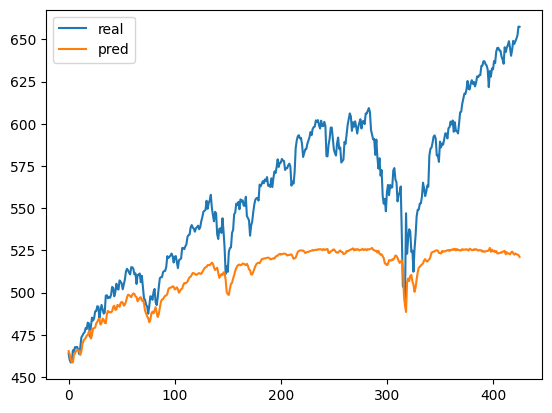

In [34]:
import seaborn as sns

sns.lineplot(x = np.arange(y_test.shape[0]), y = y_test_denorm, label = "real")
sns.lineplot(x = np.arange(y_test.shape[0]), y = predictions, label = "pred")